👉 Please upload the UTKFace zip file (from Kaggle)


Saving archive (1).zip to archive (1) (2).zip
✅ Dataset found at: /content/UTKFace
Train: 18966, Val: 2371, Test: 2371
⚡ Building new model...
Epoch 1/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 61s 71ms/step - age_loss: 297.1115 - age_mae: 12.9448 - gender_accuracy: 0.7700 - gender_loss: 0.4819 - loss: 297.5921 - val_age_loss: 153.3714 - val_age_mae: 9.1845 - val_gender_accuracy: 0.8385 - val_gender_loss: 0.3589 - val_loss: 152.6066
Epoch 2/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - age_loss: 162.1256 - age_mae: 9.6160 - gender_accuracy: 0.8266 - gender_loss: 0.3790 - loss: 162.4874 - val_age_loss: 146.0137 - val_age_mae: 8.7837 - val_gender_accuracy: 0.8427 - val_gender_loss: 0.3342 - val_loss: 143.5489
Epoch 3/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - age_loss: 153.1880 - age_mae: 9.2766 - gender_accuracy: 0.8398 - gender_loss: 0.3538 - loss: 153.5419 - val_age_loss: 132.2294 - val_age_mae: 8.5348 - val_gender_accuracy: 0.8397 - val_gender_loss: 0.3517 - val_loss: 133.3388
Epoch 4/5
593

✅ Model trained and saved at: /content/gender_age_model.h5
📊 Evaluating on Test Set...
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - age_loss: 132.3510 - age_mae: 8.3631 - gender_accuracy: 0.8327 - gender_loss: 0.3785 - loss: 132.7588
✅ Test Results: {'loss': 139.55703735351562, 'compile_metrics': 0.3695184588432312, 'gender_loss': 138.07533264160156, 'age_loss': 8.499368667602539}


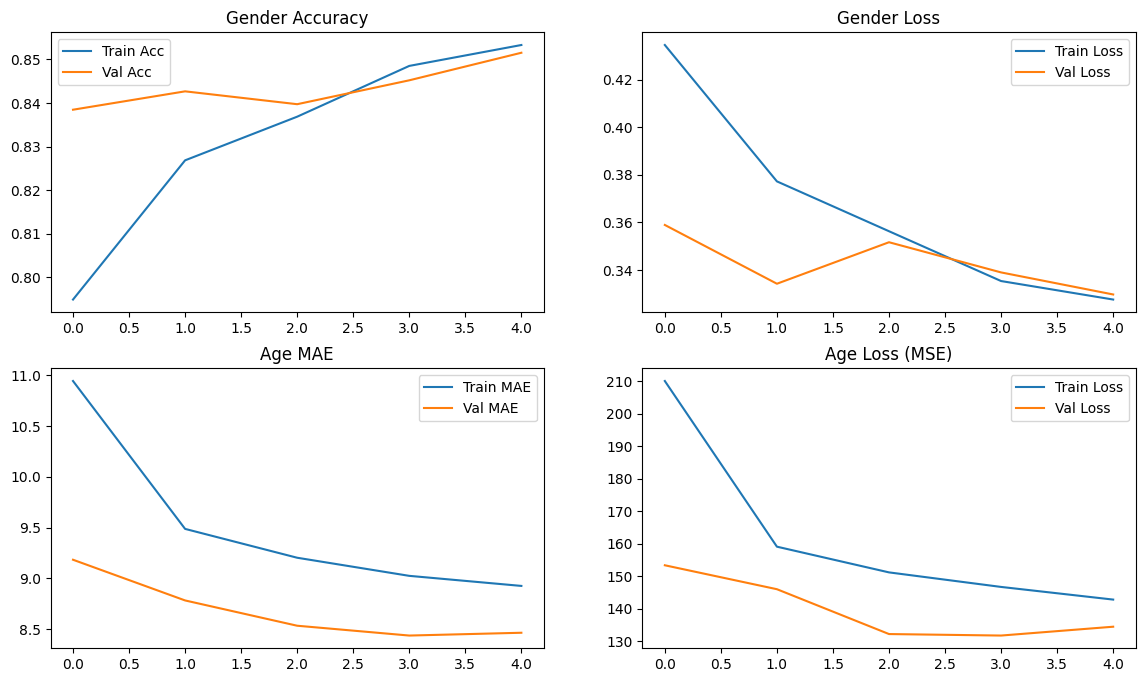

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3b8db27f6ffa5a1c61.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ==============================
# 1. Install dependencies
# ==============================
!pip install tensorflow keras opencv-python matplotlib gradio pandas --quiet

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import numpy as np
import cv2, os, zipfile
import gradio as gr
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ==============================
# 2. Upload Dataset ZIP
# ==============================
print("👉 Please upload the UTKFace zip file (from Kaggle)")
uploaded = files.upload()

zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/content")

UTK_DIR = "/content/utkface_aligned_cropped/UTKFace"
if not os.path.exists(UTK_DIR):
    if os.path.exists("/content/UTKFace"):
        UTK_DIR = "/content/UTKFace"
    else:
        raise FileNotFoundError("❌ Could not find UTKFace folder after extraction.")
print("✅ Dataset found at:", UTK_DIR)

# ==============================
# 3. Prepare CSV of image paths + labels
# ==============================
image_files, ages, genders = [], [], []

for f in os.listdir(UTK_DIR):
    if f.endswith(".jpg"):
        try:
            age, gender = f.split("_")[0:2]
            image_files.append(os.path.join(UTK_DIR, f))
            ages.append(int(age))
            genders.append(int(gender))  # 0 = Male, 1 = Female
        except:
            continue

df = pd.DataFrame({
    "filename": image_files,
    "gender": genders,
    "age": ages
})

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ==============================
# 4. Custom Data Generator for Multi-Output
# ==============================
from tensorflow.keras.utils import Sequence

class MultiOutputDataGenerator(Sequence):
    def __init__(self, df, batch_size=32, img_size=(128,128), shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]

        X = np.zeros((len(batch_df), *self.img_size, 3), dtype=np.float32)
        y_gender = np.zeros((len(batch_df),1), dtype=np.float32)
        y_age = np.zeros((len(batch_df),1), dtype=np.float32)

        for i, row in enumerate(batch_df.itertuples()):
            img = cv2.imread(row.filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0
            X[i] = img
            y_gender[i] = row.gender
            y_age[i] = row.age

        return X, {"gender": y_gender, "age": y_age}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_gen = MultiOutputDataGenerator(train_df, batch_size=32)
val_gen = MultiOutputDataGenerator(val_df, batch_size=32)
test_gen = MultiOutputDataGenerator(test_df, batch_size=32, shuffle=False)

# ==============================
# 5. Build / Load Model
# ==============================
MODEL_PATH = "/content/gender_age_model.h5"
history = None

if os.path.exists(MODEL_PATH):
    print("📂 Loading pre-trained model...")
    model = tf.keras.models.load_model(MODEL_PATH)
else:
    print("⚡ Building new model...")

    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128,128,3))
    base_model.trainable = False

    inputs = layers.Input(shape=(128,128,3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    # Gender branch
    g = layers.Dense(128, activation="relu")(x)
    g = layers.Dropout(0.3)(g)
    gender_output = layers.Dense(1, activation="sigmoid", name="gender")(g)

    # Age branch
    a = layers.Dense(128, activation="relu")(x)
    a = layers.Dropout(0.3)(a)
    age_output = layers.Dense(1, activation="linear", name="age")(a)

    model = models.Model(inputs=inputs, outputs=[gender_output, age_output])

    model.compile(
        optimizer="adam",
        loss={"gender": "binary_crossentropy", "age": "mse"},
        metrics={"gender": "accuracy", "age": "mae"}
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5  # Increase if you want higher accuracy
    )

    model.save(MODEL_PATH)
    print("✅ Model trained and saved at:", MODEL_PATH)

# ==============================
# 6. Evaluate on Test Set
# ==============================
print("📊 Evaluating on Test Set...")
test_metrics = model.evaluate(test_gen, verbose=1)
print("✅ Test Results:", dict(zip(model.metrics_names, test_metrics)))

# ==============================
# 7. Plot Training Curves
# ==============================
if history is not None:
    plt.figure(figsize=(14,8))

    plt.subplot(2,2,1)
    plt.plot(history.history['gender_accuracy'], label="Train Acc")
    plt.plot(history.history['val_gender_accuracy'], label="Val Acc")
    plt.title("Gender Accuracy")
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(history.history['gender_loss'], label="Train Loss")
    plt.plot(history.history['val_gender_loss'], label="Val Loss")
    plt.title("Gender Loss")
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(history.history['age_mae'], label="Train MAE")
    plt.plot(history.history['val_age_mae'], label="Val MAE")
    plt.title("Age MAE")
    plt.legend()

    plt.subplot(2,2,4)
    plt.plot(history.history['age_loss'], label="Train Loss")
    plt.plot(history.history['val_age_loss'], label="Val Loss")
    plt.title("Age Loss (MSE)")
    plt.legend()

    plt.show()

# ==============================
# 8. Face Detection + Prediction Function
# ==============================
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def detect_and_predict(image_input):
    img_bgr = cv2.cvtColor(image_input, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    if len(faces) == 0:
        return image_input, {"No Face Detected": 1.0}

    results = {}
    for i, (x,y,w,h) in enumerate(faces):
        face = image_input[y:y+h, x:x+w]
        face_resized = tf.image.resize(face, (128,128)) / 255.0
        face_resized = np.expand_dims(face_resized, axis=0)

        pred_gender, pred_age = model.predict(face_resized, verbose=0)
        gender = "Female" if pred_gender[0][0] > 0.5 else "Male"
        age = int(pred_age[0][0])

        results[f"Face {i+1}"] = {"Gender": gender, "Age": age}

        color = (0,255,0) if gender=="Male" else (255,0,255)
        cv2.rectangle(img_bgr, (x,y), (x+w,y+h), color, 2)
        cv2.putText(img_bgr, f"{gender}, {age}", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb, results

# ==============================
# 9. Launch Gradio Web App
# ==============================
interface = gr.Interface(
    fn=detect_and_predict,
    inputs=gr.Image(type="numpy", label="Upload Image"),
    outputs=[gr.Image(type="numpy", label="Detected Faces"), gr.JSON(label="Predictions")],
    title="👨👩 Gender + Age Detection",
    description="Upload an image. Detects faces and predicts Gender + Age with bounding boxes."
)

interface.launch(debug=True, share=True)
